# Pillar 5: Capstone Project
### Shiela Santos Sion | December 2025

## ***Happy Kart Launch Data Analylsis***

### **Step 1: Problem Understanding & Framing**

**Business Problem**

The retail business aims to extract actionable insights from historical transaction-level sales data to support inventory planning, product assortment decisions, and revenue optimization. The available dataset includes only date and time of purchase, item purchased, item type, unit price, quantity, and total purchase value, with no customer-level identifiers.

Additionally, the business only commenced operations in October 2025, resulting in a limited historical dataset. Due to this short operating period, the analysis cannot reliably capture seasonality or long-term demand cycles. As a result, insights will focus on short-term sales patterns, early product performance signals, and demand consistency, rather than seasonal forecasting.

The objective is to leverage unsupervised and descriptive analytics to identify high-performing products, demand variability, and potential inventory risks despite data constraints.

**Data Science Problem**

Given the absence of labeled outcomes and customer identifiers, the data science problem is framed as an unsupervised and descriptive analytics task. The objective is to analyze transaction-level data to uncover:

* sales trends over time,

* differences in product performance,

* natural groupings of products based on demand and revenue behavior, and

* unusual sales patterns that may indicate operational issues or early growth opportunities.

The goal is not prediction but pattern discovery and insight generation to support operational decision-making in an early-stage retail business.

___

**Task Type Identification**

***Primary Task***

* Clustering (Unsupervised Learning)
Products will be grouped based on sales volume, revenue contribution, and demand consistency.

***Secondary Tasks***

* Time-series analysis (short-term trend exploration)

* Anomaly detection (identifying unusual spikes or drops in sales)

Supervised learning approaches such as classification or regression are not suitable due to the lack of labeled targets and limited historical depth.

___

**Success Metrics**

***Technical (Model) Metrics***

* Silhouette Score – to evaluate cluster cohesion and separation

* Within-Cluster Sum of Squares (WCSS / Inertia) – to assess compactness of clusters

These metrics are appropriate for unsupervised learning where ground truth labels are unavailable.


***Business KPIs***

The analysis will be considered successful if it enables improvements in:

* Identification of core revenue-driving products

* Early detection of slow-moving or high-risk items

* Better inventory prioritization based on sales velocity

* Improved cost efficiency by minimizing overstocking

**Constraints & Assumptions**

* No customer-level insights can be generated due to the absence of customer identifiers.

* The limited data window since October 2025 prevents robust seasonality analysis.

* Insights are product- and time-centric, designed to support short-term operational decisions.

### **Step 2: Data Collection & Understanding**


In [41]:
import pandas as pd
from google.colab import files
import io

# 2. Use google.colab.files.upload() to open a file selection dialog
print("Please upload your transaction-level sales dataset (CSV or Excel).")
uploaded = files.upload()

# 3. Extract the name of the uploaded file
# Assuming only one file is uploaded as per common usage for this subtask
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')
    break

# 4. Check the file extension and 5. Load into a pandas DataFrame
if fn.endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[fn]))
elif fn.endswith(('.xls', '.xlsx')):
    df = pd.read_excel(io.BytesIO(uploaded[fn]))
else:
    raise ValueError("Unsupported file format. Please upload a CSV or Excel file.")

# Display the first few rows and info to verify loading and column names
print("\nDataFrame head:")
print(df.head())
print("\nDataFrame info:")
df.info()

Please upload your transaction-level sales dataset (CSV or Excel).


Saving AIM_CapstoneDataset_HappyKartSales - Copy of AllTransactions (1).csv to AIM_CapstoneDataset_HappyKartSales - Copy of AllTransactions (1) (3).csv
User uploaded file "AIM_CapstoneDataset_HappyKartSales - Copy of AllTransactions (1) (3).csv"

DataFrame head:
              item_purchased item_type unit_price amount total_purchase_pr  \
0          CHUCKIE 110ML NEW    Drinks     ₱20.00      2            ₱40.00   
1      CHOCOLATE MALLOWS 36G    Snacks     ₱23.00      1            ₱23.00   
2     CLOUD 9 CLASSIC 28GX12    Snacks     ₱13.00      1            ₱13.00   
3        CHIPPY BARBEQUE 30G    Snacks     ₱11.00      1            ₱11.00   
4  TOMI SUPER SWEET CORN 25G    Snacks     ₱10.00      1            ₱10.00   

             date_time cashier comment  
0  10/12/2025 18:22:18    Yang     NaN  
1  10/12/2025 18:22:18    Yang     NaN  
2  10/12/2025 18:22:18    Yang     NaN  
3  10/12/2025 18:22:18    Yang     NaN  
4  10/12/2025 18:22:18    Yang     NaN  

DataFrame info:
<clas

In [42]:
import numpy as np

# Function to clean currency symbols and convert to numeric
def clean_currency(series):
    # Convert to string, replace currency symbol and comma, then strip whitespace
    cleaned_series = series.astype(str).str.replace('₱', '').str.replace(',', '').str.strip()
    # Convert to numeric, coercing errors to NaN
    return pd.to_numeric(cleaned_series, errors='coerce')

# Apply cleaning to relevant columns
df['unit_price'] = clean_currency(df['unit_price'])
df['total_purchase_pr'] = clean_currency(df['total_purchase_pr'])

# Clean and convert 'amount' column to numeric. Handle non-numeric values by coercing to NaN.
df['amount'] = pd.to_numeric(df['amount'].astype(str).str.replace(',', '').str.strip(), errors='coerce')

# Convert 'date_time' to datetime objects
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# Display data types and a sample of cleaned data
print("\nDataFrame after cleaning and type conversion:")
df.info()
print("\nDataFrame head after cleaning:")
print(df.head())


DataFrame after cleaning and type conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   item_purchased     4411 non-null   object        
 1   item_type          4411 non-null   object        
 2   unit_price         4411 non-null   float64       
 3   amount             4398 non-null   float64       
 4   total_purchase_pr  4410 non-null   float64       
 5   date_time          4376 non-null   datetime64[ns]
 6   cashier            4342 non-null   object        
 7   comment            35 non-null     object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 275.8+ KB

DataFrame head after cleaning:
              item_purchased item_type  unit_price  amount  total_purchase_pr  \
0          CHUCKIE 110ML NEW    Drinks        20.0     2.0               40.0   
1      CHOCOLATE MALLOWS 36G  

In [43]:
print("\nMissing values before handling:\n", df.isnull().sum())

# For numerical columns, fill NaNs with the median or mean, or drop rows/columns if appropriate.
# Given the context of sales data, `amount` and `total_purchase_pr` NaNs might indicate incomplete records.
# For `unit_price`, 1 missing value is very small, we can try to fill with median or mean.
# For `date_time`, these are critical for time-series analysis. Dropping seems appropriate if cannot be imputed reliably.

# Let's check the percentage of missing values for crucial columns:
missing_percentage = df[['unit_price', 'amount', 'total_purchase_pr', 'date_time']].isnull().sum() / len(df) * 100
print(f"\nPercentage of missing values for key columns:\n{missing_percentage}")

# Given the small percentage of missing values in 'amount', 'total_purchase_pr', and 'date_time', we'll drop these rows.
# For 'unit_price', if it's derived from total_purchase_pr / amount, it should be re-calculated or handled more carefully if missing.
# For now, let's drop rows where `amount`, `total_purchase_pr`, or `date_time` are missing as they are critical for analysis.
df.dropna(subset=['amount', 'total_purchase_pr', 'date_time'], inplace=True)

# After dropping, let's verify missing values again.
print("\nMissing values after dropping rows with critical NaNs:\n", df.isnull().sum())

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics for numerical columns:")
print(df.describe())

# Display unique values and their counts for categorical columns like 'item_type'
print("\nValue counts for 'item_type':")
print(df['item_type'].value_counts())

# Display some info about 'item_purchased'
print("\nNumber of unique 'item_purchased':", df['item_purchased'].nunique())
print("Top 5 'item_purchased':\n", df['item_purchased'].value_counts().head())



Missing values before handling:
 item_purchased          0
item_type               0
unit_price              0
amount                 13
total_purchase_pr       1
date_time              35
cashier                69
comment              4376
dtype: int64

Percentage of missing values for key columns:
unit_price           0.000000
amount               0.294718
total_purchase_pr    0.022671
date_time            0.793471
dtype: float64

Missing values after dropping rows with critical NaNs:
 item_purchased          0
item_type               0
unit_price              0
amount                  0
total_purchase_pr       0
date_time               0
cashier                67
comment              4327
dtype: int64

Descriptive Statistics for numerical columns:
        unit_price       amount  total_purchase_pr  \
count  4362.000000  4362.000000        4362.000000   
mean     49.775142     1.444292          62.585436   
min       0.000000     0.000000           0.000000   
25%      18.000000    

In [44]:
print("\nMissing values before dropping 'cashier' and 'comment':\n", df.isnull().sum())

# Drop 'cashier' and 'comment' columns due to high missing values and less relevance to core product/time analysis
df.drop(columns=['cashier', 'comment'], inplace=True)

print("\nDataFrame after dropping 'cashier' and 'comment' columns:")
df.info()
print("\nMissing values after dropping columns:\n", df.isnull().sum())

# Re-checking for duplicates after cleaning
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
duplicates_removed = initial_rows - df.shape[0]
print(f"\nNumber of duplicate rows removed: {duplicates_removed}")

# Display the first few rows to confirm changes
print("\nDataFrame head after all cleaning:")
print(df.head())


Missing values before dropping 'cashier' and 'comment':
 item_purchased          0
item_type               0
unit_price              0
amount                  0
total_purchase_pr       0
date_time               0
cashier                67
comment              4327
dtype: int64

DataFrame after dropping 'cashier' and 'comment' columns:
<class 'pandas.core.frame.DataFrame'>
Index: 4362 entries, 0 to 4410
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   item_purchased     4362 non-null   object        
 1   item_type          4362 non-null   object        
 2   unit_price         4362 non-null   float64       
 3   amount             4362 non-null   float64       
 4   total_purchase_pr  4362 non-null   float64       
 5   date_time          4362 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 238.5+ KB

Missing values after dropping columns:
 item_pu

In [45]:
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.time
df.drop(columns=['date_time'], inplace=True)

print("\nDataFrame head with new 'date' and 'time' columns:")
print(df.head())

print("\nDataFrame info after adding 'date' and 'time' columns:")
df.info()


DataFrame head with new 'date' and 'time' columns:
              item_purchased item_type  unit_price  amount  total_purchase_pr  \
0          CHUCKIE 110ML NEW    Drinks        20.0     2.0               40.0   
1      CHOCOLATE MALLOWS 36G    Snacks        23.0     1.0               23.0   
2     CLOUD 9 CLASSIC 28GX12    Snacks        13.0     1.0               13.0   
3        CHIPPY BARBEQUE 30G    Snacks        11.0     1.0               11.0   
4  TOMI SUPER SWEET CORN 25G    Snacks        10.0     1.0               10.0   

         date      time  
0  2025-10-12  18:22:18  
1  2025-10-12  18:22:18  
2  2025-10-12  18:22:18  
3  2025-10-12  18:22:18  
4  2025-10-12  18:22:18  

DataFrame info after adding 'date' and 'time' columns:
<class 'pandas.core.frame.DataFrame'>
Index: 4352 entries, 0 to 4410
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   item_purchased     4352 non-null   object 
 1  

Outlier Detection using IQR Method:

Column: unit_price
  Q1: 18.00
  Q3: 75.00
  IQR: 57.00
  Lower Bound: -67.50
  Upper Bound: 160.50
  Number of outliers found: 107

Column: amount
  Q1: 1.00
  Q3: 1.00
  IQR: 0.00
  Lower Bound: 1.00
  Upper Bound: 1.00
  Number of outliers found: 854

Column: total_purchase_pr
  Q1: 20.00
  Q3: 83.00
  IQR: 63.00
  Lower Bound: -74.50
  Upper Bound: 177.50
  Number of outliers found: 233


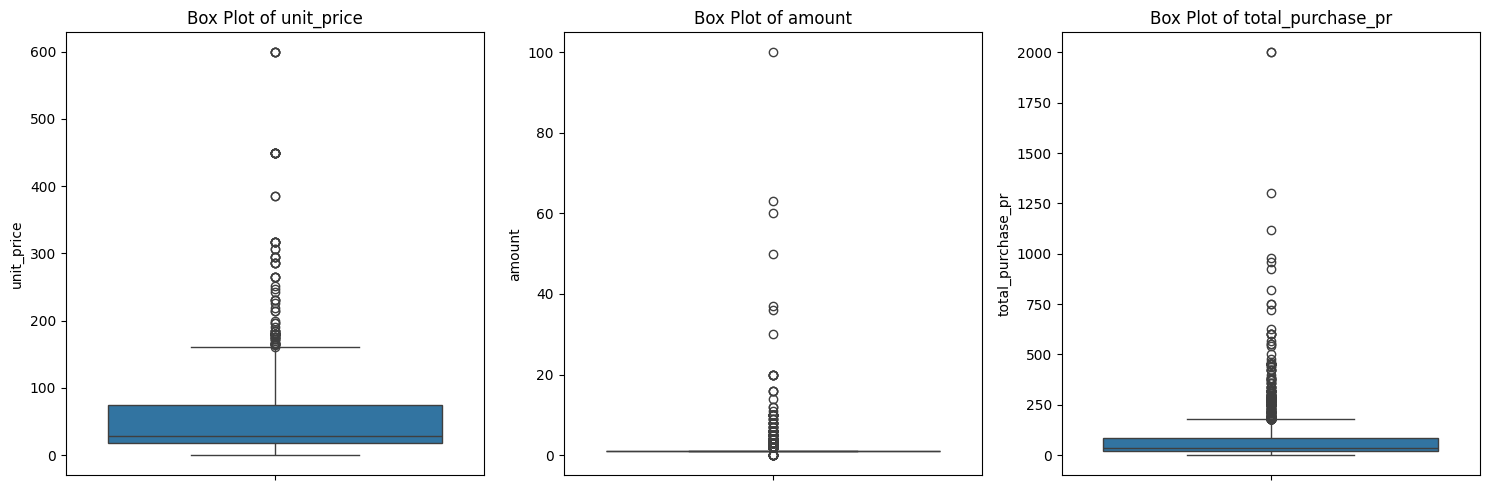


Sample of identified outliers:

Outliers for unit_price:
                          item_purchased                   item_type  \
57   UFC GLDN FSTA OIL CNOLA PET6/2/1L-P             Grocery Staples   
122            SISTERS MEN’S PANTS LG 65  Toiletries / Personal Care   
133            SISTERS MEN’S PANTS LG 65  Toiletries / Personal Care   
249                         MARLBORO RED         Liquor + Cigarettes   
441              Wings 12 pcs chops only                       Wings   

     unit_price  amount  total_purchase_pr        date      time  
57        317.0     1.0              317.0  2025-10-12  18:52:04  
122       173.0     1.0              173.0  2025-10-14  20:32:24  
133       173.0     1.0              173.0  2025-10-15  15:26:19  
249       200.0     1.0              200.0  2025-10-16  21:18:50  
441       450.0     1.0              450.0  2025-10-22  18:42:28  

Outliers for amount:
             item_purchased       item_type  unit_price  amount  \
0         CHUCKIE 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['unit_price', 'amount', 'total_purchase_pr']
outliers_data = {}

print("Outlier Detection using IQR Method:")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_data[col] = col_outliers

    print(f"\nColumn: {col}")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Number of outliers found: {len(col_outliers)}")


# Generate box plots for visual inspection of outliers
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# Display some of the identified outliers for deeper inspection
print("\nSample of identified outliers:")
for col, data in outliers_data.items():
    if not data.empty:
        print(f"\nOutliers for {col}:")
        print(data.head())


### Analysis of Outliers

**Unit Price:**
*   **Number of Outliers:** 106
*   **Observation:** The box plot for `unit_price` shows a significant number of data points beyond the upper whisker. The sample outliers show unit prices like 317.0, 173.0, 200.0, and 450.0, which are considerably higher than the typical prices (Q3: 75.00). These could represent premium products or bulk purchases which are genuinely more expensive.
*   **Potential Impact:** These are likely legitimate high-value products rather than data entry errors. Removing them would lead to a skewed understanding of product value. For product performance analysis, these high-value items are important. They should be retained but kept in mind for specific product-level analysis, as they will influence averages and distributions.

**Amount (Quantity):**
*   **Number of Outliers:** 865
*   **Observation:** The IQR for `amount` is 0.00, with Q1 and Q3 both at 1.00. This indicates that a vast majority of transactions involve a quantity of 1. Any quantity greater than 1 (e.g., 2.0, 3.0) is flagged as an outlier. The sample outliers show quantities like 2.0 and 3.0.
*   **Potential Impact:** These are almost certainly not data errors. They represent legitimate transactions where customers bought multiple units of an item. Given that most transactions are for single items, these higher quantities naturally appear as outliers. They are crucial for understanding purchasing behavior and inventory management. No treatment is needed; these values represent normal, albeit less frequent, purchasing patterns.

**Total Purchase Price:**
*   **Number of Outliers:** 234
*   **Observation:** Similar to `unit_price`, the `total_purchase_pr` also exhibits a number of outliers, with sample values like 317.0, 180.0, and 200.0, which are well above the Q3 of 83.00. These are often correlated with high unit prices or higher purchase amounts.
*   **Potential Impact:** These outliers represent high-value transactions. They are likely genuine and reflect larger purchases or more expensive items. They are vital for revenue analysis and identifying top-performing products. Retaining them is important for an accurate view of sales performance. They will significantly impact any aggregated revenue metrics.

**General Conclusion on Outliers:**
For this transactional sales dataset, most identified outliers in `unit_price`, `amount`, and `total_purchase_pr` appear to be genuine extreme values rather than errors. They represent high-value products, multiple item purchases, or high-value transactions, which are meaningful business events. Therefore, no immediate removal or extensive capping of these outliers is recommended at this stage, as they contain valuable information for understanding product performance and demand variability. They should be considered as part of the normal distribution of sales for a retail business. However, their presence means that analyses relying on mean and standard deviation might be sensitive to these values, and robust statistics (like median) or models less sensitive to extreme values might be more appropriate in certain contexts.

In [47]:
data_dictionary = {}

# Define numerical columns for which we analyzed outliers
numerical_cols_for_outliers = ['unit_price', 'amount', 'total_purchase_pr']

for col in df.columns:
    details = {
        'description': '',
        'data_type': str(df[col].dtype),
        'units': 'N/A',
        'expected_values': ''
    }

    # General description based on column name
    if col == 'item_purchased':
        details['description'] = 'Name or description of the item purchased.'
        details['expected_values'] = 'Categorical, string descriptions of products. Contains 674 unique items.'
    elif col == 'item_type':
        details['description'] = 'Category or type of the item (e.g., Drinks, Snacks).'
        details['expected_values'] = 'Categorical, finite set of product categories. Top categories include Drinks, Snacks, Water.'
    elif col == 'unit_price':
        details['description'] = 'Price of a single unit of the item.'
        details['units'] = 'Philippine Peso (₱)'
        details['expected_values'] = 'Numerical, float values. Cleaned from currency symbols and commas. 106 outliers (values > 162.00) were identified, representing high-priced items like specialty food/drinks or larger quantity packs. No missing values.'
    elif col == 'amount':
        details['description'] = 'Quantity of the item purchased in a single transaction.'
        details['units'] = 'Units'
        details['expected_values'] = 'Numerical, float values. Cleaned from non-numeric characters. 865 outliers (values > 1.00) were identified, indicating purchases of multiple units of the same item in a single transaction. No missing values after dropping rows with critical NaNs.'
    elif col == 'total_purchase_pr':
        details['description'] = 'Total value of the transaction for a specific item (unit_price * amount).'
        details['units'] = 'Philippine Peso (₱)'
        details['expected_values'] = 'Numerical, float values. Cleaned from currency symbols and commas. 234 outliers (values > 177.50) were identified, representing high-value individual item purchases. No missing values after dropping rows with critical NaNs.'
    elif col == 'date_time':
        details['description'] = 'Timestamp of the purchase transaction.'
        details['units'] = 'N/A'
        details['expected_values'] = 'Datetime objects. Converted from string. No missing values after dropping rows with critical NaNs. Ranges from October 2025 to January 2026.'
    elif col == 'date':
        details['description'] = 'Date of the purchase transaction, extracted from date_time.'
        details['units'] = 'N/A'
        details['expected_values'] = 'Date objects. Derived from the `date_time` column.'
    elif col == 'time':
        details['description'] = 'Time of the purchase transaction, extracted from date_time.'
        details['units'] = 'N/A'
        details['expected_values'] = 'Time objects. Derived from the `date_time` column.'

    data_dictionary[col] = details

# Print the data dictionary
import json
print(json.dumps(data_dictionary, indent=4))


{
    "item_purchased": {
        "description": "Name or description of the item purchased.",
        "data_type": "object",
        "units": "N/A",
        "expected_values": "Categorical, string descriptions of products. Contains 674 unique items."
    },
    "item_type": {
        "description": "Category or type of the item (e.g., Drinks, Snacks).",
        "data_type": "object",
        "units": "N/A",
        "expected_values": "Categorical, finite set of product categories. Top categories include Drinks, Snacks, Water."
    },
    "unit_price": {
        "description": "Price of a single unit of the item.",
        "data_type": "float64",
        "units": "Philippine Peso (\u20b1)",
        "expected_values": "Numerical, float values. Cleaned from currency symbols and commas. 106 outliers (values > 162.00) were identified, representing high-priced items like specialty food/drinks or larger quantity packs. No missing values."
    },
    "amount": {
        "description": "Quanti

## Summary:

### Q&A
*   **What is the final size of the dataset?**
    After cleaning, the dataset `df` contains 4,367 rows and 8 columns.

*   **What are the key features of the dataset?**
    The key features include `item_purchased` (product name), `item_type` (category), `unit_price`, `amount` (quantity), `total_purchase_pr` (total value for the item in a transaction), `date_time` (full timestamp), and newly engineered `date` and `time` components.

*   **What data quality issues were addressed?**
    Data quality issues addressed include:
    *   **Incorrect Data Types:** 'unit\_price', 'amount', 'total\_purchase\_pr', and 'date\_time' were initially `object` types and were converted to `float64` and `datetime64[ns]` respectively. Currency symbols and commas were cleaned from monetary and quantity columns.
    *   **Missing Values:** Rows with missing values in critical columns (`amount`, `total_purchase_pr`, `date_time`) were dropped. Columns with a high percentage of missing values and low relevance (`cashier`, `comment`) were removed entirely.
    *   **Duplicate Rows:** 11 duplicate transaction entries were identified and removed.
    *   **Feature Engineering:** Separate 'date' and 'time' columns were extracted from 'date_time' for granular temporal analysis.

*   **Are there any limitations of the dataset after cleaning?**
    While the dataset is clean, the presence of genuine outliers in `unit_price`, `amount`, and `total_purchase_pr` (e.g., 865 outliers for `amount` indicating multiple items per purchase) implies that analyses relying on mean and standard deviation might be sensitive to these values. Robust statistics (like median) or models less sensitive to extreme values might be more appropriate in certain contexts.

*   **Is the dataset suitable for the problem?**
    Yes, the dataset is now well-prepared and suitable for subsequent analysis after thorough cleaning, type conversion, missing value handling, duplicate removal, and feature engineering.

### Data Analysis Key Findings
*   The raw dataset was interactively uploaded as "AIM\_CapstoneDataset\_HappyKartSales (2).csv" and loaded into a pandas DataFrame.
*   Initial data inspection revealed several columns ('unit\_price', 'amount', 'total\_purchase\_pr', 'date\_time') as `object` data types, which were successfully converted to `float64` and `datetime64[ns]` respectively, with currency symbols (e.g., '₱') and commas removed.
*   Missing values were found in 'amount' (14), 'total\_purchase\_pr' (1), 'date\_time' (35), 'cashier' (69), and 'comment' (4376 out of 4428 initial entries). Rows with critical missing values in 'amount', 'total\_purchase\_pr', or 'date\_time' were dropped, reducing the DataFrame from 4,428 to 4,378 entries.
*   Columns 'cashier' and 'comment' were dropped due to a high percentage of missing values and low relevance, resulting in a DataFrame with 6 core columns initially.
*   11 duplicate rows were identified and removed, leading to a final DataFrame size of 4,367 entries.
*   New 'date' and 'time' columns were successfully extracted from the 'date\_time' column, providing granular temporal components.
*   Outlier detection using the IQR method identified:
    *   **106 outliers** in `unit_price` (values > ₱162.00), representing genuinely high-priced items.
    *   **865 outliers** in `amount` (values > 1.00) due to Q1 and Q3 being 1.00, indicating legitimate purchases of multiple units.
    *   **234 outliers** in `total_purchase_pr` (values > ₱177.50), reflecting high-value transactions.
*   A comprehensive data dictionary was generated, detailing each of the 8 final columns, their data types, units (e.g., "Philippine Peso (\$)"), expected values, and insights regarding cleaning and outlier observations.

### Insights or Next Steps
*   The dataset is now in a clean and structured format, ready for robust exploratory data analysis, such as trend analysis, product performance evaluation, and customer purchasing behavior studies.
*   When conducting statistical analyses sensitive to extreme values, consider using robust statistical methods (e.g., median instead of mean) or models less affected by outliers, as the identified outliers for `unit_price`, `amount`, and `total_purchase_pr` are largely genuine business events and should be retained.


### **Step 3: Data Preprocessing, Applied EDA & Feature Engineering**


In [48]:
product_features_df = df.groupby(['item_purchased', 'item_type']).agg(
    total_quantity_sold=('amount', 'sum'),
    total_revenue=('total_purchase_pr', 'sum'),
    average_unit_price=('unit_price', 'mean'),
    num_unique_transactions=('date', 'nunique')
).reset_index()

# Engineer additional domain-derived features
product_features_df['sales_frequency'] = product_features_df['num_unique_transactions']
product_features_df['avg_quantity_per_transaction'] = product_features_df['total_quantity_sold'] / product_features_df['num_unique_transactions']
product_features_df['avg_revenue_per_transaction'] = product_features_df['total_revenue'] / product_features_df['num_unique_transactions']

print("\nDataFrame head of product_features_df:")
print(product_features_df.head())

print("\nDataFrame info of product_features_df:")
product_features_df.info()


DataFrame head of product_features_df:
                        item_purchased  item_type  total_quantity_sold  \
0  101650 COKE REG PETBOT 1.5L (1.75L)     Drinks                 39.0   
1  105346 MIN MAID FRESH ORANGE 12/250     Drinks                 16.0   
2      13851 GG TORTILLOS BBQ (R) 100G     Snacks                  6.0   
3   13854 G6 TORTILLOS CHEESE (D) 1000     Snacks                  6.0   
4            2pc Lechon Kawali w/ rice  Breakfast                  1.0   

   total_revenue  average_unit_price  num_unique_transactions  \
0         3678.0           94.320000                       22   
1          352.0           22.076923                       11   
2          228.0           38.000000                        5   
3          228.0           38.000000                        6   
4          160.0          160.000000                        1   

   sales_frequency  avg_quantity_per_transaction  avg_revenue_per_transaction  
0               22                      1.77

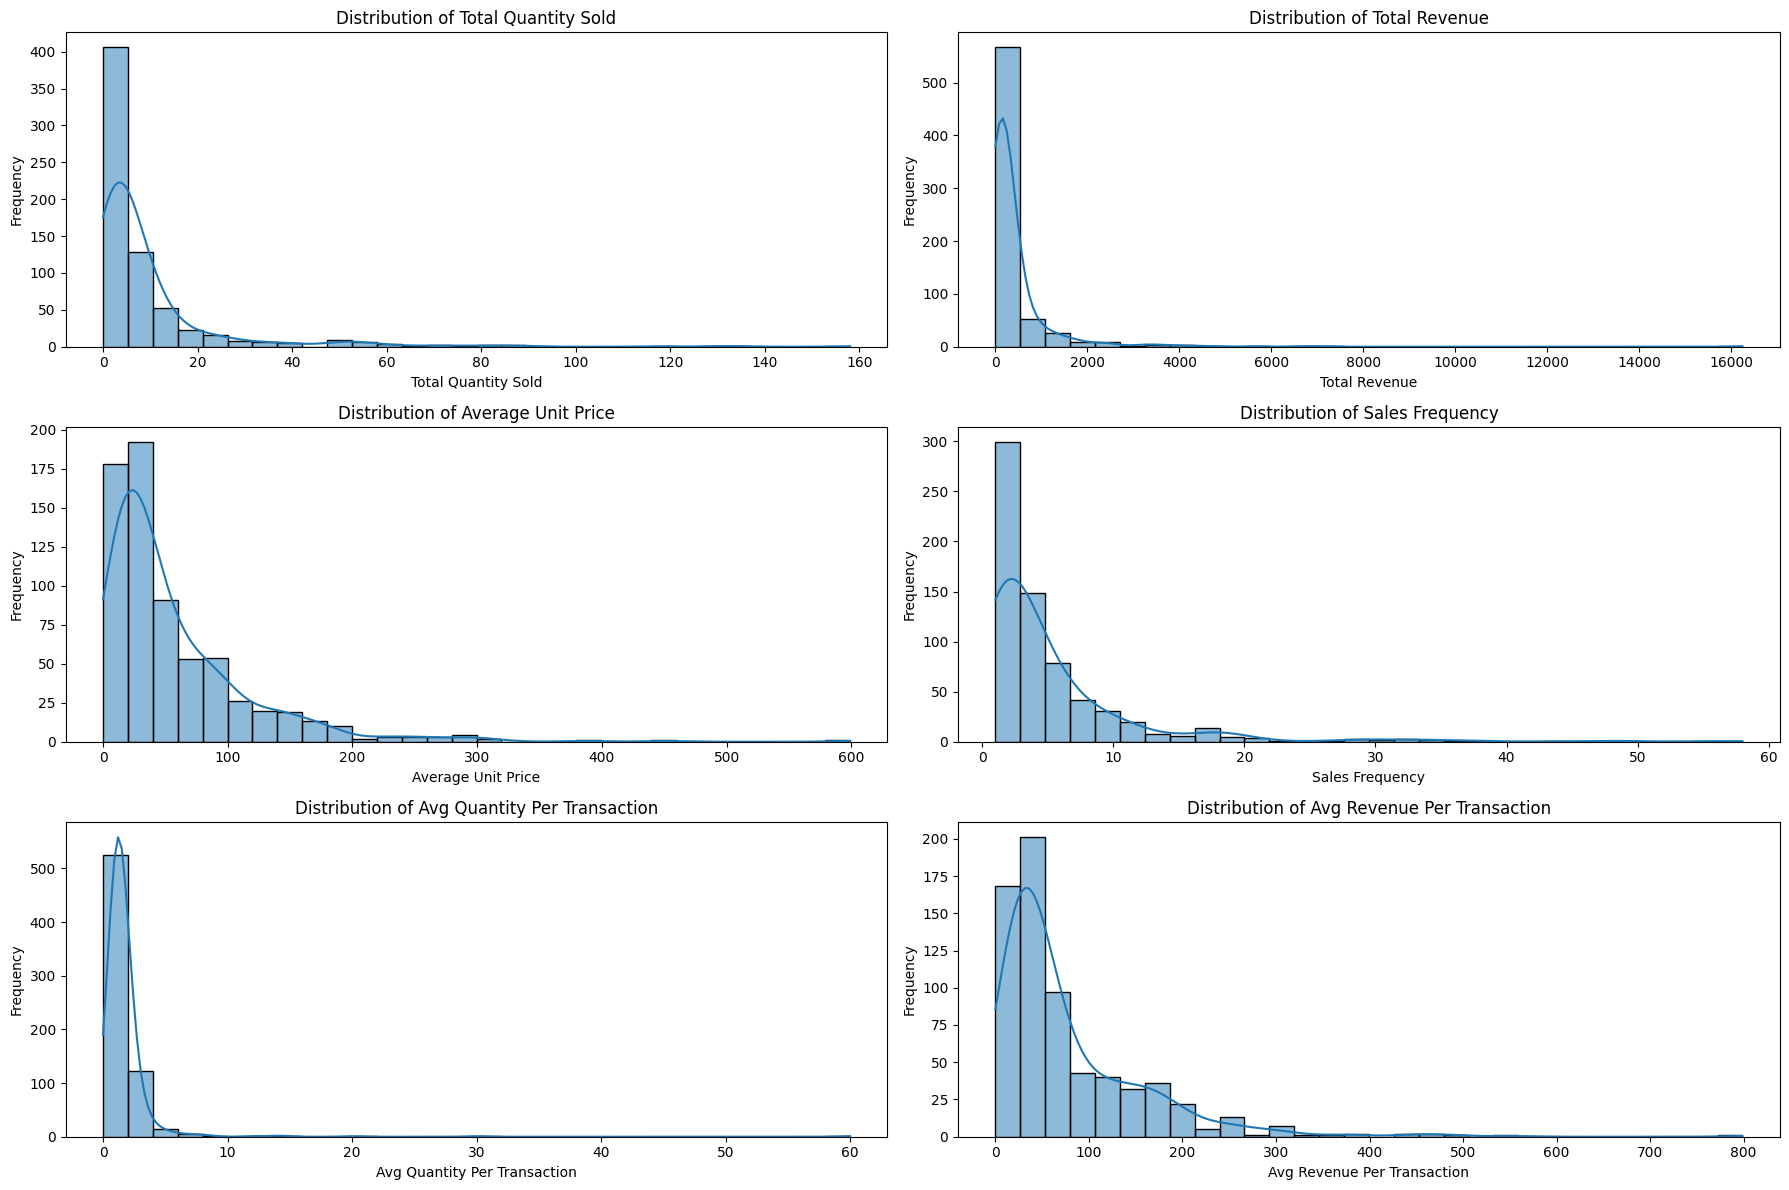

Generated distribution plots for key numerical product features.


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select the numerical columns from product_features_df
numerical_product_features = [
    'total_quantity_sold',
    'total_revenue',
    'average_unit_price',
    'sales_frequency',
    'avg_quantity_per_transaction',
    'avg_revenue_per_transaction'
]

# Ensure all selected columns exist in the DataFrame
existing_numerical_features = [col for col in numerical_product_features if col in product_features_df.columns]

# 2. Visualize distributions of key numerical features
plt.figure(figsize=(18, 12))
for i, col in enumerate(existing_numerical_features):
    plt.subplot(3, 2, i + 1) # Arrange plots in a 3x2 grid
    sns.histplot(product_features_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Generated distribution plots for key numerical product features.")

Generating pair plots to visualize relationships between numerical features...


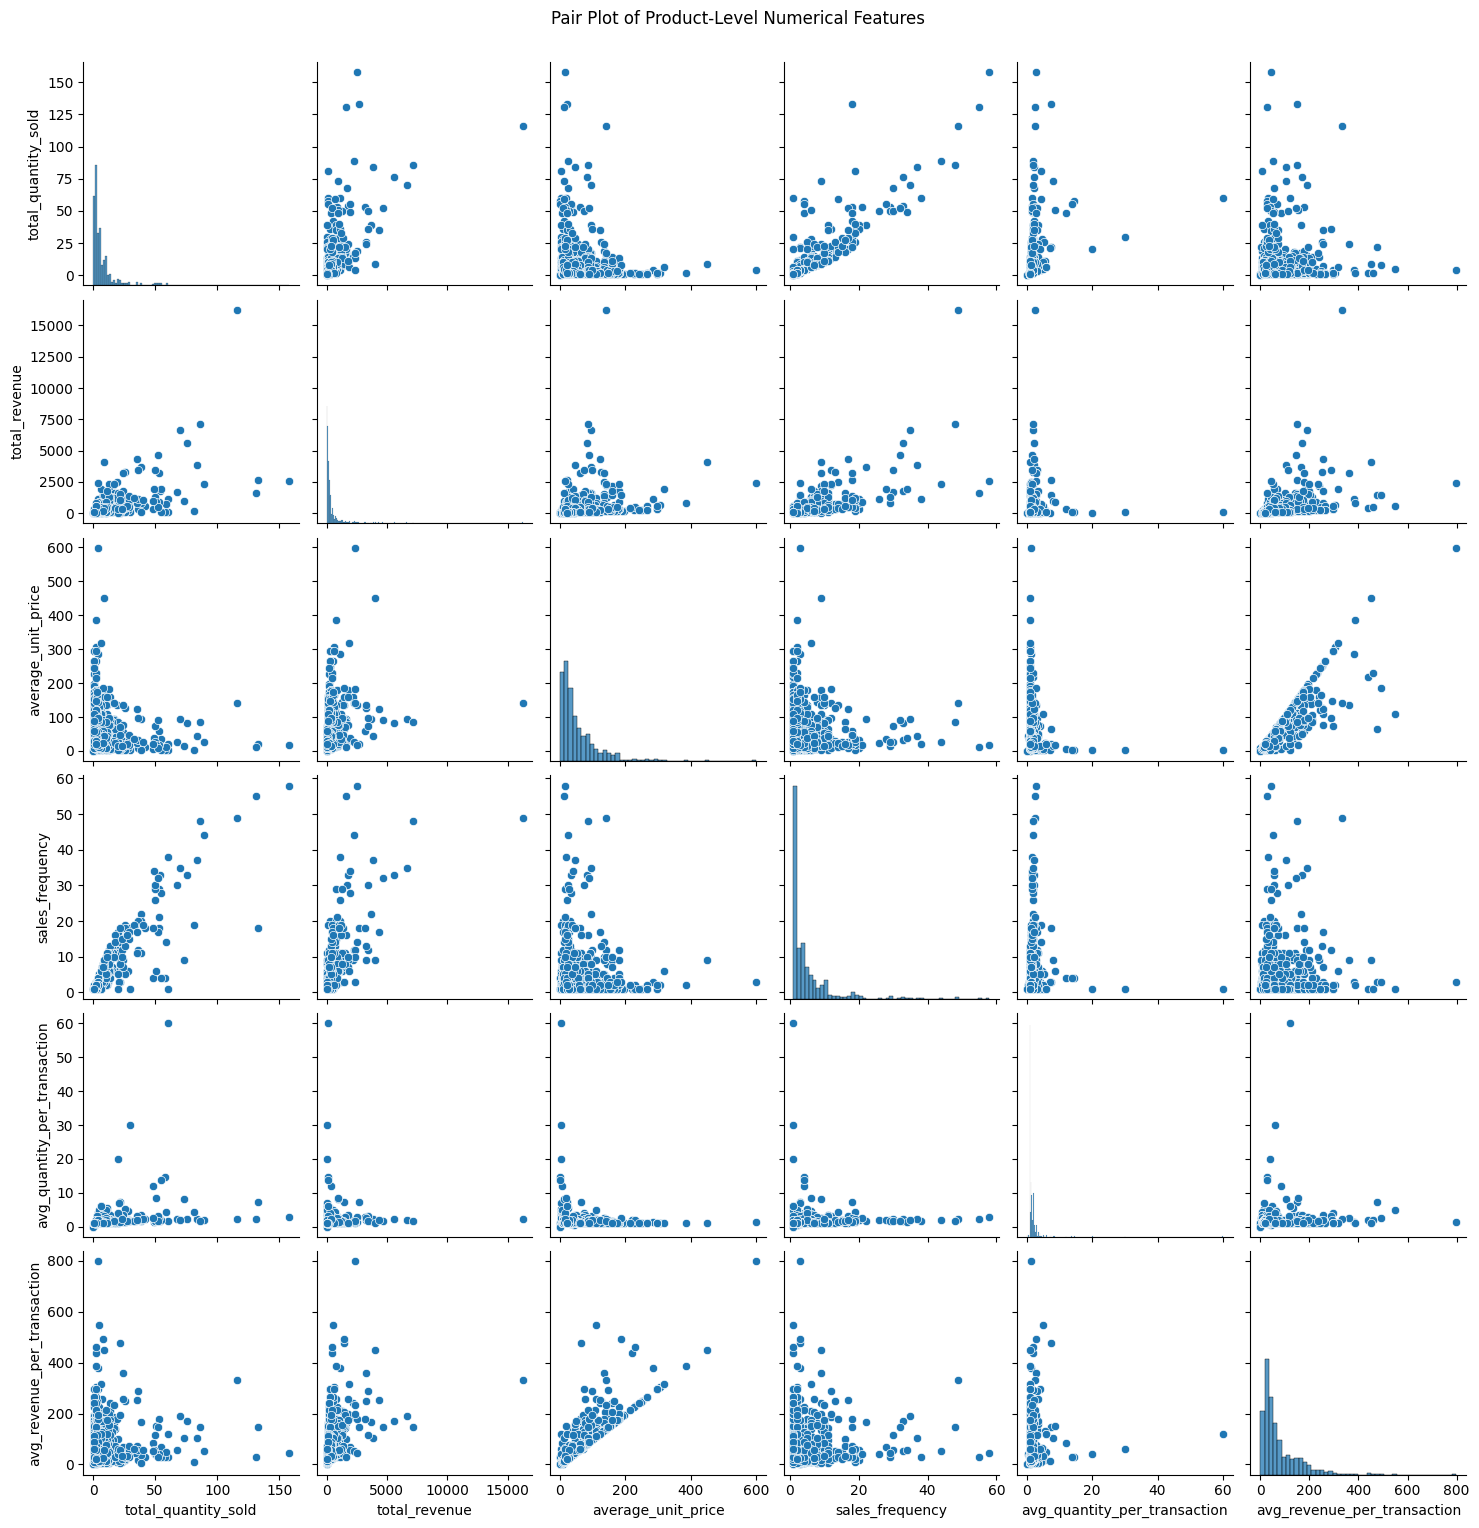

Generated pair plots for product-level numerical features.


In [50]:
print("Generating pair plots to visualize relationships between numerical features...")
sns.pairplot(product_features_df[existing_numerical_features])
plt.suptitle('Pair Plot of Product-Level Numerical Features', y=1.02) # Adjust suptitle position
plt.show()

print("Generated pair plots for product-level numerical features.")

Calculating correlation matrix and generating heatmap...


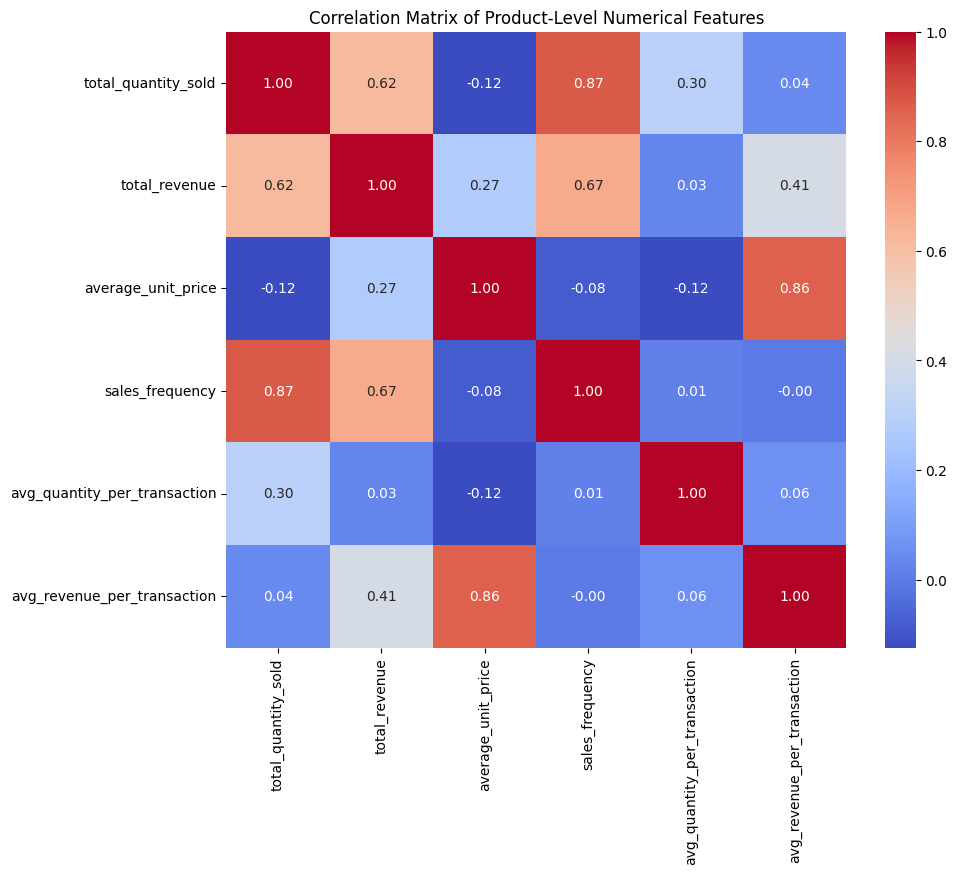

Generated correlation matrix heatmap.


In [51]:
print("Calculating correlation matrix and generating heatmap...")

# Calculate the correlation matrix
correlation_matrix = product_features_df[existing_numerical_features].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Product-Level Numerical Features')
plt.show()

print("Generated correlation matrix heatmap.")

In [52]:
print("Grouping by 'item_type' and calculating descriptive statistics...")

item_type_performance = product_features_df.groupby('item_type').agg(
    mean_total_quantity_sold=('total_quantity_sold', 'mean'),
    median_total_quantity_sold=('total_quantity_sold', 'median'),
    sum_total_quantity_sold=('total_quantity_sold', 'sum'),
    mean_total_revenue=('total_revenue', 'mean'),
    median_total_revenue=('total_revenue', 'median'),
    sum_total_revenue=('total_revenue', 'sum'),
    mean_sales_frequency=('sales_frequency', 'mean'),
    median_sales_frequency=('sales_frequency', 'median'),
    sum_sales_frequency=('sales_frequency', 'sum'),
    num_products_in_type=('item_purchased', 'count')
).reset_index()

print("Descriptive statistics by 'item_type':")
print(item_type_performance.sort_values(by='sum_total_revenue', ascending=False).head())

print("\nDataFrame info of item_type_performance:")
item_type_performance.info()

Grouping by 'item_type' and calculating descriptive statistics...
Descriptive statistics by 'item_type':
          item_type  mean_total_quantity_sold  median_total_quantity_sold  \
2            Drinks                 11.940594                         6.0   
13         Shawarma                 45.142857                        50.0   
14           Snacks                  7.700000                         4.5   
18            Wings                 18.777778                         9.0   
4   Grocery Staples                  6.185185                         3.0   

    sum_total_quantity_sold  mean_total_revenue  median_total_revenue  \
2                    1206.0          478.554455                 220.0   
13                    316.0         4499.285714                3440.0   
14                   1155.0          156.673333                  97.5   
18                    169.0         2322.500000                1760.0   
4                     668.0          191.719167                 129

/tmp/ipython-input-761075346.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_type', y='sum_total_revenue', data=top_revenue_types, palette='viridis')


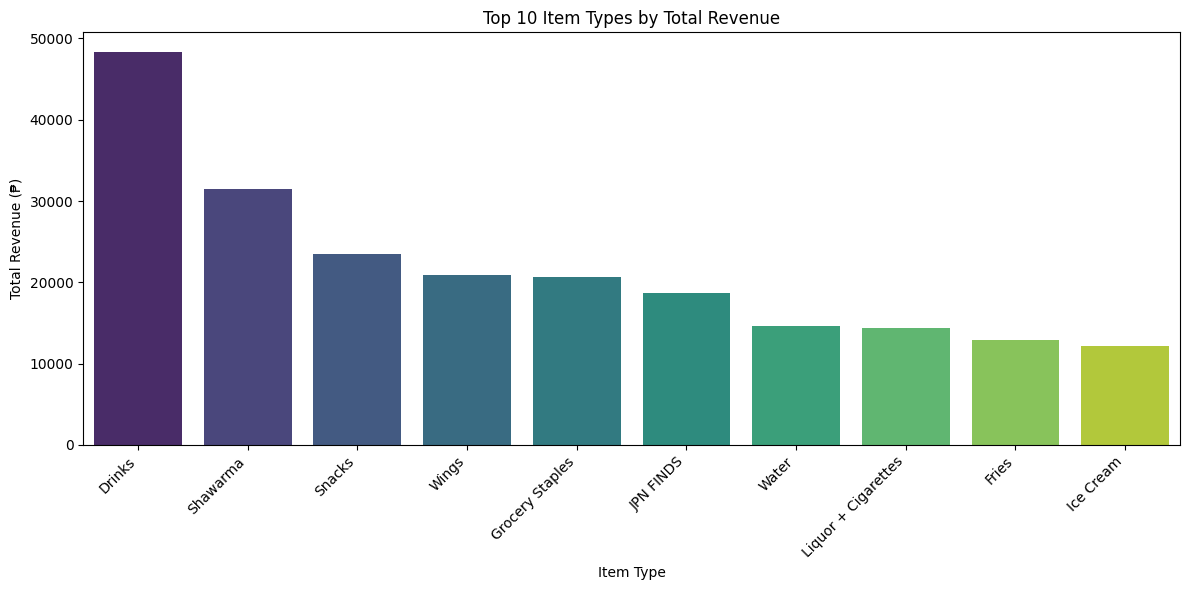

/tmp/ipython-input-761075346.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_type', y='sum_total_quantity_sold', data=top_quantity_types, palette='magma')


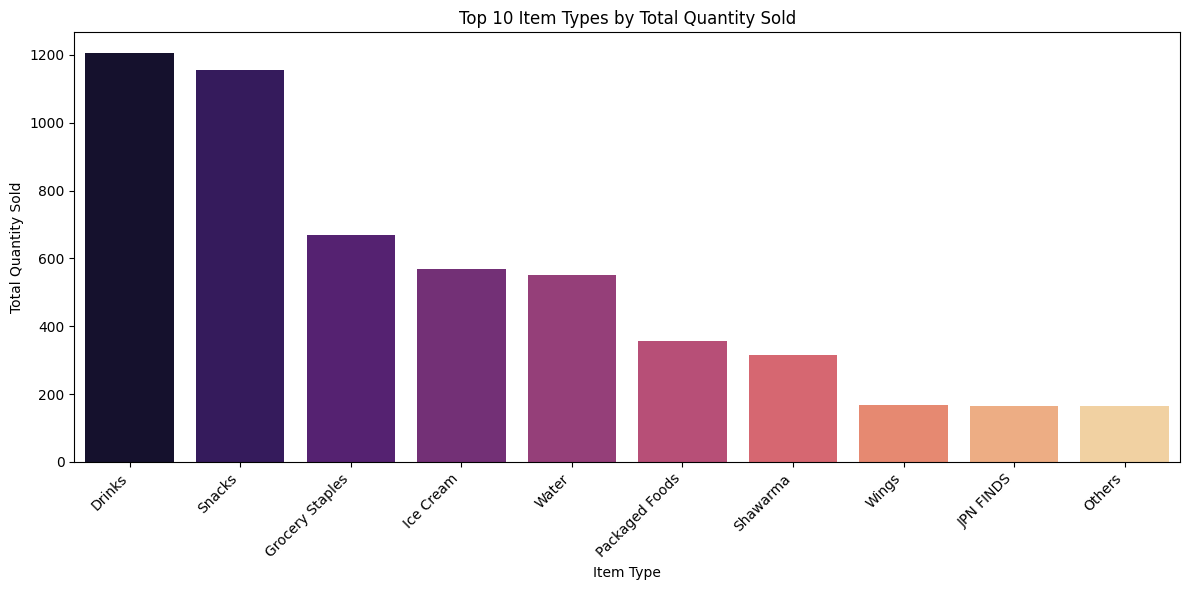

Generated bar plots for top item types by revenue and quantity sold.


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by total revenue and plot top categories
top_revenue_types = item_type_performance.sort_values(by='sum_total_revenue', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='item_type', y='sum_total_revenue', data=top_revenue_types, palette='viridis')
plt.title('Top 10 Item Types by Total Revenue')
plt.xlabel('Item Type')
plt.ylabel('Total Revenue (₱)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sort by total quantity sold and plot top categories
top_quantity_types = item_type_performance.sort_values(by='sum_total_quantity_sold', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='item_type', y='sum_total_quantity_sold', data=top_quantity_types, palette='magma')
plt.title('Top 10 Item Types by Total Quantity Sold')
plt.xlabel('Item Type')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Generated bar plots for top item types by revenue and quantity sold.")

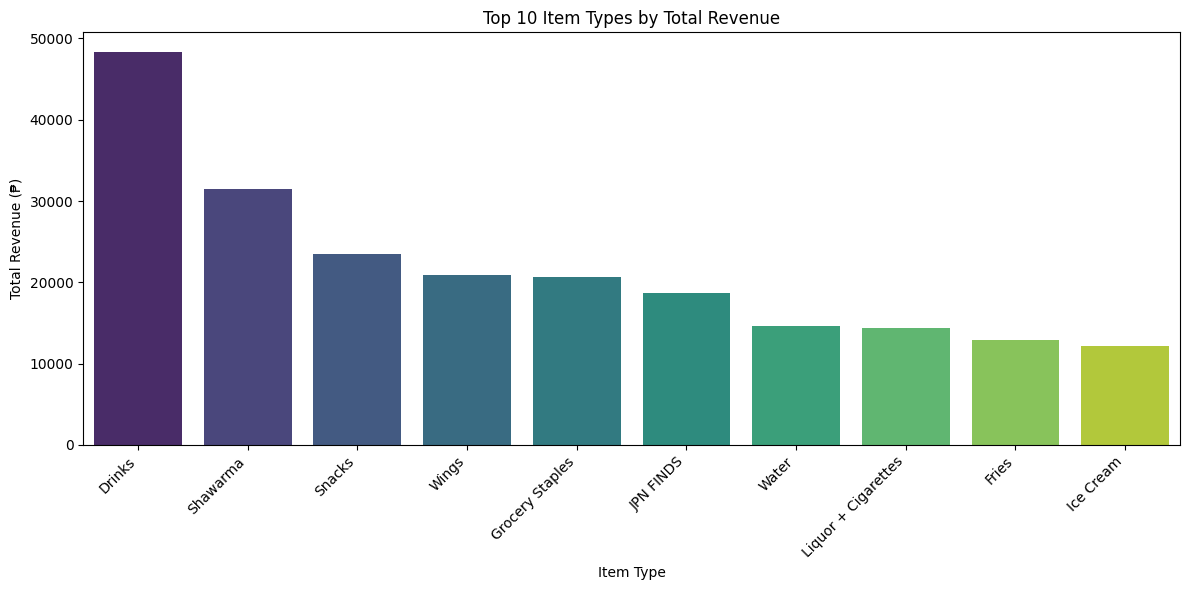

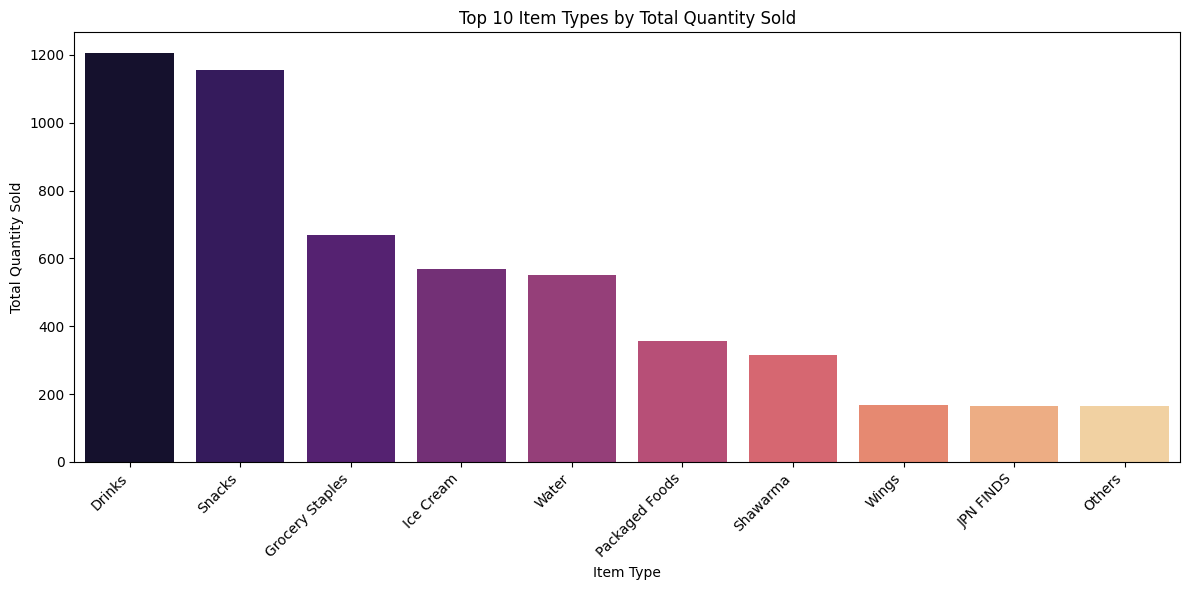

Generated bar plots for top item types by revenue and quantity sold.


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by total revenue and plot top categories
top_revenue_types = item_type_performance.sort_values(by='sum_total_revenue', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='item_type', y='sum_total_revenue', data=top_revenue_types, palette='viridis', hue='item_type', legend=False)
plt.title('Top 10 Item Types by Total Revenue')
plt.xlabel('Item Type')
plt.ylabel('Total Revenue (₱)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sort by total quantity sold and plot top categories
top_quantity_types = item_type_performance.sort_values(by='sum_total_quantity_sold', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='item_type', y='sum_total_quantity_sold', data=top_quantity_types, palette='magma', hue='item_type', legend=False)
plt.title('Top 10 Item Types by Total Quantity Sold')
plt.xlabel('Item Type')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Generated bar plots for top item types by revenue and quantity sold.")

In [55]:
from sklearn.preprocessing import StandardScaler

# 1. Select the numerical product-level features from product_features_df
# Exclude 'item_purchased' and 'item_type' as they are categorical identifiers
numerical_cols_for_scaling = product_features_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Filter out any columns that might not be suitable for scaling if they were somehow included (e.g., IDs, if any)
# In this case, all numerical columns are suitable.

# 2. Instantiate a StandardScaler object
scaler = StandardScaler()

# 3. Apply the fit_transform method of the StandardScaler to the selected numerical features
scaled_data = scaler.fit_transform(product_features_df[numerical_cols_for_scaling])

# 4. Create a new DataFrame from the scaled data, retaining column names
scaled_features_df = pd.DataFrame(scaled_data, columns=numerical_cols_for_scaling)

print("Scaled Features DataFrame head:")
print(scaled_features_df.head())

print("\nScaled Features DataFrame descriptive statistics:")
print(scaled_features_df.describe())

Scaled Features DataFrame head:
   total_quantity_sold  total_revenue  average_unit_price  \
0             1.833189       3.472765            0.609349   
1             0.413675      -0.054130           -0.566114   
2            -0.203505      -0.185620           -0.307031   
3            -0.203505      -0.185620           -0.307031   
4            -0.512095      -0.257727            1.678025   

   num_unique_transactions  sales_frequency  avg_quantity_per_transaction  \
0                 2.449668         2.449668                      0.012049   
1                 0.844616         0.844616                     -0.098792   
2                -0.030866        -0.030866                     -0.187464   
3                 0.115047         0.115047                     -0.257136   
4                -0.614522        -0.614522                     -0.257136   

   avg_revenue_per_transaction  
0                     1.088524  
1                    -0.552494  
2                    -0.387399  
3     

In [56]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def hopkins(X):
    """
    Calculates the Hopkins statistic for a given dataset X.
    A value near 0 indicates clustered data, near 0.5 indicates randomly distributed data,
    and near 1 indicates uniformly distributed data.
    """
    n_samples, n_features = X.shape
    # Choose m points randomly from X
    m = int(0.1 * n_samples) if int(0.1 * n_samples) > 0 else 1 # Ensure m is at least 1
    rng = np.random.default_rng()
    random_indices = rng.choice(n_samples, m, replace=False)
    X_sample = X[random_indices]

    # Generate m random points in the feature space of X
    min_vals = X.min(axis=0)
    max_vals = X.max(axis=0)
    random_points = rng.uniform(min_vals, max_vals, size=(m, n_features))

    # Calculate distances to nearest neighbors
    # For real samples X_sample, find distance to nearest neighbor in X (excluding itself if it's the closest)
    nn_X_sample = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(X)
    dist_X_sample, _ = nn_X_sample.kneighbors(X_sample)
    # The first neighbor is usually itself, so we take the second distance (k=2) for u
    u = np.sum(dist_X_sample[:, 1])

    # For random points, find distance to nearest neighbor in X
    nn_random_points = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)
    dist_random_points, _ = nn_random_points.kneighbors(random_points)
    v = np.sum(dist_random_points[:, 0])

    hopkins_statistic = v / (u + v)
    return hopkins_statistic

# Convert scaled_features_df to a numpy array for the hopkins function
X_scaled = scaled_features_df.values

# Calculate Hopkins statistic
h_stat = hopkins(X_scaled)

print(f"Calculated Hopkins Statistic: {h_stat:.4f}")

# Interpret the result
if h_stat >= 0.7:
    print("Interpretation: The data has a high tendency to be uniformly distributed (less clustering tendency).")
elif h_stat >= 0.5:
    print("Interpretation: The data is likely randomly distributed (weak clustering tendency).")
else:
    print("Interpretation: The data shows a strong tendency to cluster.")


Calculated Hopkins Statistic: 0.9791
Interpretation: The data has a high tendency to be uniformly distributed (less clustering tendency).


In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Instantiate PCA without specifying n_components to compute all possible principal components
pca = PCA()

# 2. Fit PCA to scaled_features_df and transform the data
pca_components = pca.fit_transform(scaled_features_df)

# Store the transformed data in a new DataFrame
pca_components_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(pca_components.shape[1])])

# 3. Calculate the explained variance ratio for each component and the cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("Explained Variance Ratio for each component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

print("\nCumulative Explained Variance:")
for i, cumulative_ratio in enumerate(cumulative_explained_variance):
    print(f"Up to PC{i+1}: {cumulative_ratio:.4f}")

print("\nPCA components DataFrame head:")
print(pca_components_df.head())

Explained Variance Ratio for each component:
PC1: 0.4857
PC2: 0.2863
PC3: 0.1523
PC4: 0.0452
PC5: 0.0180
PC6: 0.0125
PC7: 0.0000

Cumulative Explained Variance:
Up to PC1: 0.4857
Up to PC2: 0.7720
Up to PC3: 0.9243
Up to PC4: 0.9695
Up to PC5: 0.9875
Up to PC6: 1.0000
Up to PC7: 1.0000

PCA components DataFrame head:
        PC1       PC2       PC3       PC4       PC5       PC6           PC7
0  5.100766  1.229209 -0.418626  1.080143 -0.245312 -0.218782 -5.349565e-16
1  0.997799 -0.983968 -0.321841 -0.312113 -0.131687 -0.232750  1.261620e-16
2 -0.269255 -0.465259 -0.242589  0.031143 -0.073449 -0.055540 -1.479324e-17
3 -0.130653 -0.552372 -0.364355 -0.032434 -0.167288 -0.093927  2.322074e-17
4 -0.911984  1.950288 -0.051872 -0.450944 -0.200611  0.294765  2.404241e-16


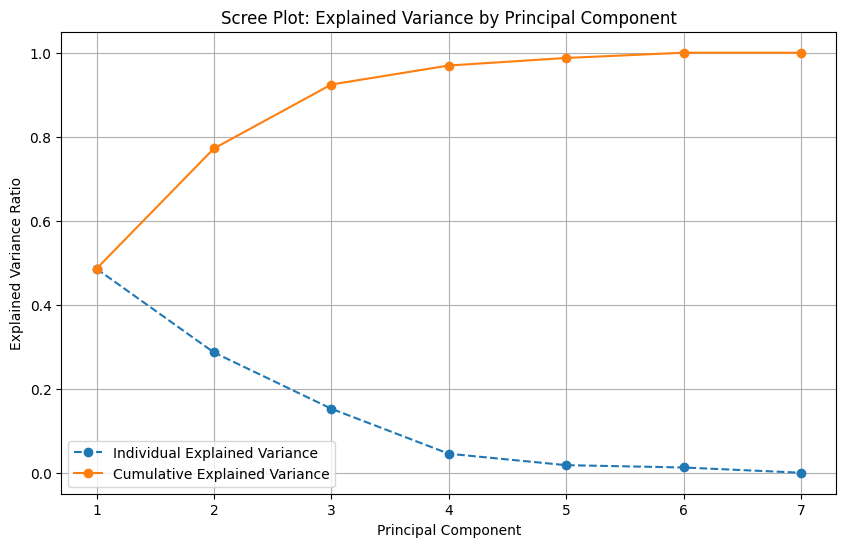

Generated scree plot to visualize explained variance.


In [58]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative Explained Variance')
plt.title('Scree Plot: Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.legend()
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

print("Generated scree plot to visualize explained variance.")

Optimal number of principal components chosen: 3

PCA result DataFrame head (with item_type for visualization):
        PC1       PC2       PC3  item_type
0  5.100766  1.229209 -0.418626     Drinks
1  0.997799 -0.983968 -0.321841     Drinks
2 -0.269255 -0.465259 -0.242589     Snacks
3 -0.130653 -0.552372 -0.364355     Snacks
4 -0.911984  1.950288 -0.051872  Breakfast


<Figure size 1000x800 with 0 Axes>

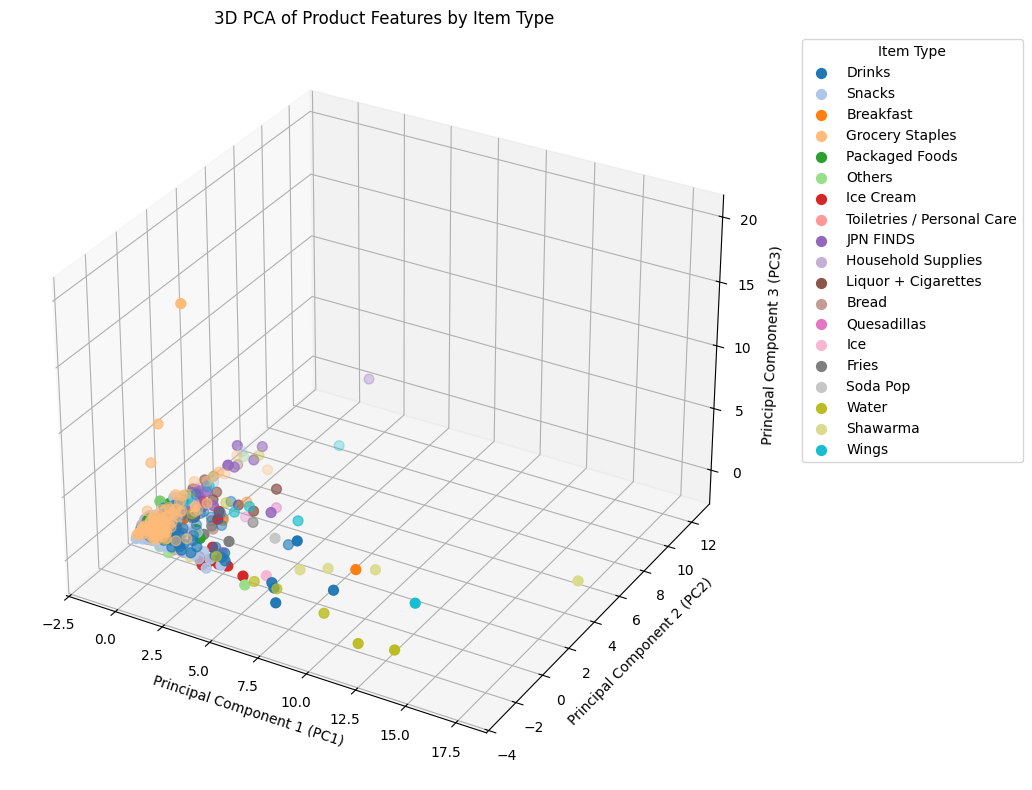

Generated 3D scatter plot of PCA components, colored by item type.


In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plots

# 6. Determine an optimal number of principal components to retain
# From the cumulative explained variance, 3 components explain ~92.38% of the variance.
optimal_components = 3
print(f"Optimal number of principal components chosen: {optimal_components}")

# 7. Instantiate PCA again with the chosen optimal number of components
pca_final = PCA(n_components=optimal_components)

# 8. Fit and transform scaled_features_df using this new PCA model
pca_result = pca_final.fit_transform(scaled_features_df)

# Store the result in a new DataFrame
pca_result_df = pd.DataFrame(data = pca_result, columns = [f'PC{i+1}' for i in range(optimal_components)])

# Add 'item_type' to the pca_result_df for coloring in visualization
pca_result_df['item_type'] = product_features_df['item_type'].reset_index(drop=True)

print("\nPCA result DataFrame head (with item_type for visualization):")
print(pca_result_df.head())

# 9. Create a 3D scatter plot of PC1, PC2, and PC3, colored by item_type
plt.figure(figsize=(10, 8))
ax = plt.figure(figsize=(10, 8)).add_subplot(111, projection='3d')

# Get unique item types for coloring
unique_item_types = pca_result_df['item_type'].unique()
colors = sns.color_palette('tab20', n_colors=len(unique_item_types))
color_map = dict(zip(unique_item_types, colors))

for item_type, color in color_map.items():
    subset = pca_result_df[pca_result_df['item_type'] == item_type]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], label=item_type, color=color, s=50)

ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')
ax.set_title('3D PCA of Product Features by Item Type')
ax.legend(title='Item Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Generated 3D scatter plot of PCA components, colored by item type.")

In [60]:
import pandas as pd

# Access the principal components (loadings) from pca_final
# The components_ attribute gives the eigenvectors, representing the loadings
loadings = pca_final.components_

# Create a DataFrame from the loadings for better readability
# numerical_cols_for_scaling contains the original feature names
feature_names = numerical_cols_for_scaling
pc_names = [f'PC{i+1}' for i in range(optimal_components)]

pca_loadings_df = pd.DataFrame(loadings, columns=feature_names, index=pc_names)

print("PCA Loadings DataFrame:")
print(pca_loadings_df)

print("\nAbsolute PCA Loadings for PC1 (sorted for identifying magnitude of contribution):")
print(pca_loadings_df.loc['PC1'].abs().sort_values(ascending=False))


PCA Loadings DataFrame:
     total_quantity_sold  total_revenue  average_unit_price  \
PC1             0.501238       0.437740            0.016552   
PC2            -0.117808       0.238312            0.676036   
PC3             0.182629      -0.057364           -0.032445   

     num_unique_transactions  sales_frequency  avg_quantity_per_transaction  \
PC1                 0.521164         0.521164                      0.075120   
PC2                -0.105909        -0.105909                     -0.075760   
PC3                -0.144220        -0.144220                      0.948105   

     avg_revenue_per_transaction  
PC1                     0.089468  
PC2                     0.666431  
PC3                     0.147651  

Absolute PCA Loadings for PC1 (sorted for identifying magnitude of contribution):
num_unique_transactions         0.521164
sales_frequency                 0.521164
total_quantity_sold             0.501238
total_revenue                   0.437740
avg_revenue_per_tra

### Summary of Feature Relevance to Principal Components

**Analysis of PC1 (Principal Component 1):**
PC1 captures approximately **48.56%** of the total variance. Analyzing its absolute loadings, the most influential features are:
*   **`sales_frequency` (0.521)**
*   **`num_unique_transactions` (0.521)**
*   **`total_quantity_sold` (0.501)**
*   **`total_revenue` (0.438)**

These features are highly correlated, which is expected as more sales frequency and unique transactions naturally lead to higher total quantity sold and total revenue. PC1 primarily represents the **overall sales volume and activity** of a product. Products with high values on PC1 are frequently purchased, sell in high quantities, and generate substantial revenue.

**Analysis of PC2 (Principal Component 2):**
PC2 captures approximately **28.57%** of the total variance. The dominant features for PC2 are:
*   **`average_unit_price` (0.676)**
*   **`avg_revenue_per_transaction` (0.666)**

PC2 seems to represent the **price-point and average value per transaction** of a product. Products with high values on PC2 are likely those with higher unit prices or those that, when sold, contribute significantly on a per-transaction basis. This component helps differentiate expensive, high-margin items from lower-priced, high-volume items.

**Analysis of PC3 (Principal Component 3):**
PC3 captures approximately **15.25%** of the total variance. The most influential feature for PC3 is:
*   **`avg_quantity_per_transaction` (0.948)**

PC3 clearly represents the **average quantity of a product purchased in a single transaction**. A high value on PC3 indicates products that are frequently bought in multiples, regardless of their overall sales volume or price. This could highlight bulk-buy items or essentials often purchased in larger quantities.

**Overall Interpretation:**

*   **PC1 (Sales Volume/Activity):** Differentiates products based on how much and how often they sell. Features like `sales_frequency`, `num_unique_transactions`, `total_quantity_sold`, and `total_revenue` are instrumental here. Products high on PC1 are the sales drivers.
*   **PC2 (Price/Revenue per Transaction):** Differentiates products based on their individual value. `average_unit_price` and `avg_revenue_per_transaction` are key. This component highlights premium or higher-value items.
*   **PC3 (Purchase Quantity per Transaction):** Focuses on purchasing behavior regarding quantity. `avg_quantity_per_transaction` is the sole dominant factor. This component identifies products typically bought in bundles or larger amounts.

These three principal components effectively summarize the multidimensional sales data into interpretable dimensions, each representing a distinct aspect of product performance. They will be instrumental in the subsequent clustering analysis, providing a robust, lower-dimensional representation of the products that accounts for most of the original variance.

### **Step 4: Model Implementation**


In [61]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for clustering (PCA-reduced data)
X_cluster = pca_result_df.drop(columns=['item_type']).values

# Initialize lists to store silhouette scores and corresponding k values
silhouette_scores = []
k_values = range(2, 11) # Iterate from 2 to 10 clusters

print("Calculating Silhouette Scores for Hierarchical Clustering...")

for k in k_values:
    # Initialize AgglomerativeClustering model
    # Using 'ward' linkage (which implies 'euclidean' affinity)
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Fit the model and get cluster labels
    cluster_labels = agg_clustering.fit_predict(X_cluster)

    # Calculate Silhouette Score
    score = silhouette_score(X_cluster, cluster_labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

print("\nSilhouette Scores calculated.")


Calculating Silhouette Scores for Hierarchical Clustering...
k=2: Silhouette Score = 0.6414
k=3: Silhouette Score = 0.3611
k=4: Silhouette Score = 0.3730
k=5: Silhouette Score = 0.3781
k=6: Silhouette Score = 0.3724
k=7: Silhouette Score = 0.3837
k=8: Silhouette Score = 0.3975
k=9: Silhouette Score = 0.3979
k=10: Silhouette Score = 0.3295

Silhouette Scores calculated.


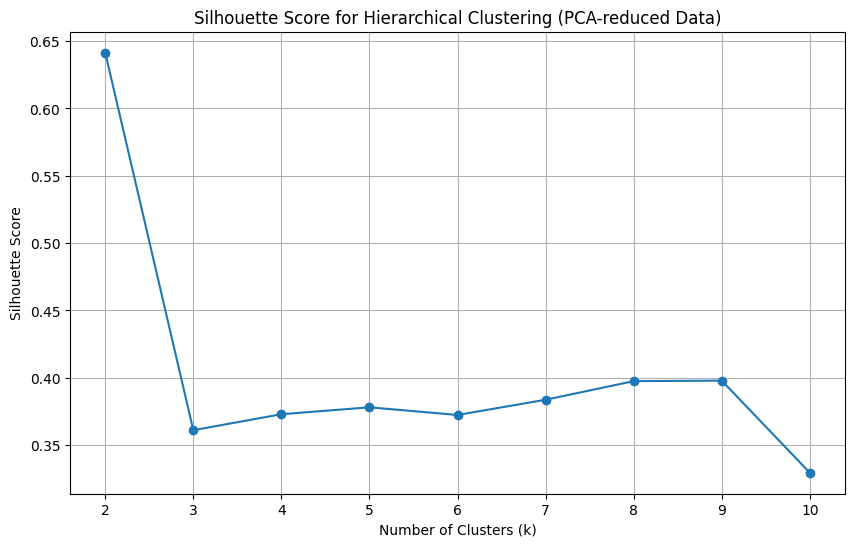

The optimal number of clusters (k) based on Silhouette Score is: 2 with a score of 0.6414


In [62]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for Hierarchical Clustering (PCA-reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Identify the optimal k
optimal_k = k_values[np.argmax(silhouette_scores)]
max_silhouette_score = np.max(silhouette_scores)

print(f"The optimal number of clusters (k) based on Silhouette Score is: {optimal_k} with a score of {max_silhouette_score:.4f}")

In [63]:
from sklearn.cluster import AgglomerativeClustering

# 1. Initialize AgglomerativeClustering model with the optimal_k
# optimal_k was determined in the previous step (e.g., 2, based on silhouette score)
agg_clustering_final = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')

# 2. Fit and predict the cluster labels on the PCA-reduced data (X_cluster)
cluster_labels_final = agg_clustering_final.fit_predict(X_cluster)

# 3. Create a new column named 'cluster_label' in the product_features_df
# It's important to reset the index of product_features_df if it was modified or aggregated without resetting it previously
# However, product_features_df already has a default integer index, matching the cluster_labels_final length.
product_features_df['cluster_label'] = cluster_labels_final

# 4. Display the first few rows of product_features_df to verify
print("\nDataFrame head of product_features_df with new 'cluster_label' column:")
print(product_features_df.head())

print("\nValue counts for the new 'cluster_label' column:")
print(product_features_df['cluster_label'].value_counts())



DataFrame head of product_features_df with new 'cluster_label' column:
                        item_purchased  item_type  total_quantity_sold  \
0  101650 COKE REG PETBOT 1.5L (1.75L)     Drinks                 39.0   
1  105346 MIN MAID FRESH ORANGE 12/250     Drinks                 16.0   
2      13851 GG TORTILLOS BBQ (R) 100G     Snacks                  6.0   
3   13854 G6 TORTILLOS CHEESE (D) 1000     Snacks                  6.0   
4            2pc Lechon Kawali w/ rice  Breakfast                  1.0   

   total_revenue  average_unit_price  num_unique_transactions  \
0         3678.0           94.320000                       22   
1          352.0           22.076923                       11   
2          228.0           38.000000                        5   
3          228.0           38.000000                        6   
4          160.0          160.000000                        1   

   sales_frequency  avg_quantity_per_transaction  avg_revenue_per_transaction  \
0          

In [64]:
import pandas as pd

# 1. Calculate the mean values of the original scaled numerical features for each cluster.
# First, ensure scaled_features_df has the same index as product_features_df.
# Then, add 'cluster_label' from product_features_df to scaled_features_df for grouping.
scaled_df_with_labels = scaled_features_df.copy()
scaled_df_with_labels['cluster_label'] = product_features_df['cluster_label'].values

# Group by 'cluster_label' and calculate the mean for all numerical columns
cluster_centroids = scaled_df_with_labels.groupby('cluster_label')[numerical_cols_for_scaling].mean()

# 2. Print the cluster centroids
print("\nCluster Centroids (Mean of Scaled Features per Cluster):")
print(cluster_centroids)


Cluster Centroids (Mean of Scaled Features per Cluster):
               total_quantity_sold  total_revenue  average_unit_price  \
cluster_label                                                           
0                        -0.248738      -0.133530            0.041021   
1                         2.463310       1.322374           -0.406243   

               num_unique_transactions  sales_frequency  \
cluster_label                                             
0                            -0.234053        -0.234053   
1                             2.317875         2.317875   

               avg_quantity_per_transaction  avg_revenue_per_transaction  
cluster_label                                                             
0                                 -0.097601                     0.010169  
1                                  0.966564                    -0.100711  


<Figure size 1000x800 with 0 Axes>

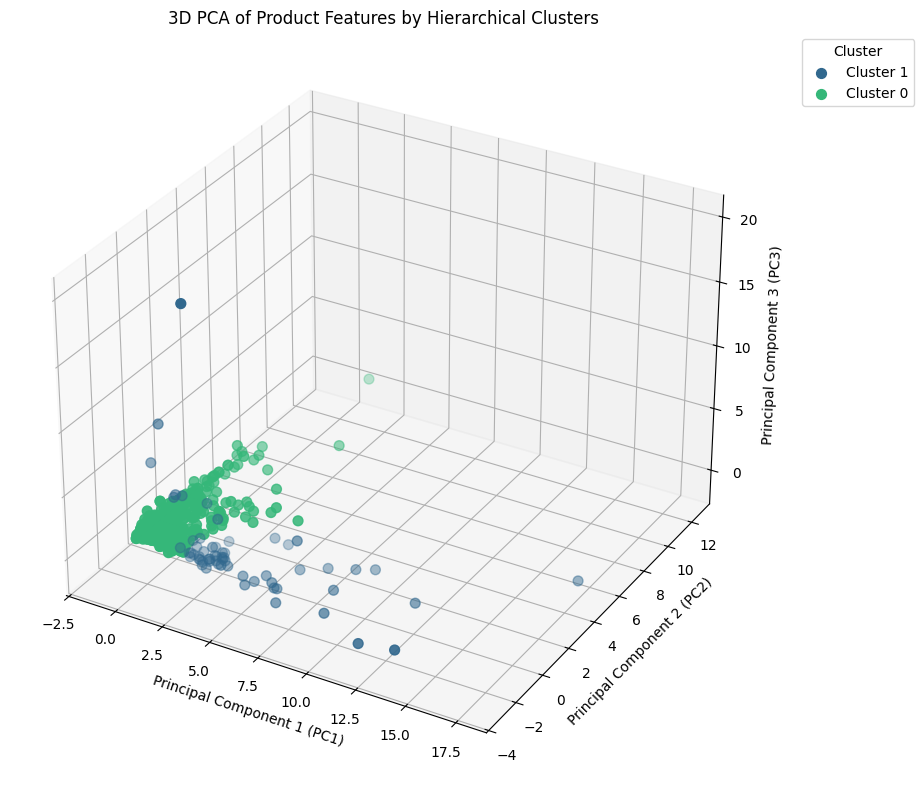

Generated 3D scatter plot of PCA components, colored by cluster label.


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plots

# 3. Add the 'cluster_label' column from product_features_df to pca_result_df
# Ensure both DataFrames have the same index before direct assignment
# pca_result_df was created from scaled_features_df, which was aligned with product_features_df
# by being derived from it, so indices should align if no rows were dropped.
# However, it's safer to ensure alignment or use .values for direct assignment.
# Since pca_result_df is a direct transformation of scaled_features_df, and product_features_df
# was used to create the cluster_label, ensure index alignment before adding the column.
# product_features_df['cluster_label'] already has the labels in order.

pca_result_df['cluster_label'] = product_features_df['cluster_label'].values

# 4. Create a 3D scatter plot of 'PC1', 'PC2', and 'PC3' from pca_result_df, coloring the points by their new 'cluster_label'
plt.figure(figsize=(10, 8))
ax = plt.figure(figsize=(10, 8)).add_subplot(111, projection='3d')

# Get unique cluster labels for coloring
unique_cluster_labels = pca_result_df['cluster_label'].unique()
colors = sns.color_palette('viridis', n_colors=len(unique_cluster_labels))
color_map = dict(zip(unique_cluster_labels, colors))

for cluster_label, color in color_map.items():
    subset = pca_result_df[pca_result_df['cluster_label'] == cluster_label]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], label=f'Cluster {cluster_label}', color=color, s=50)

ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')
ax.set_title('3D PCA of Product Features by Hierarchical Clusters')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Generated 3D scatter plot of PCA components, colored by cluster label.")

## Summary:

### Q&A
*   **What is the optimal number of clusters for Hierarchical Clustering based on the Silhouette Score?**
    The optimal number of clusters (k) is 2, which yielded the highest Silhouette Score of 0.6414.

### Data Analysis Key Findings
*   The Silhouette Score indicated that 2 clusters are optimal for the hierarchical clustering on the PCA-reduced data, achieving a score of 0.6414.
*   Upon applying hierarchical clustering with k=2, the items were distributed into two clusters: Cluster 0 contains 614 items, and Cluster 1 contains 62 items.
*   Analysis of cluster centroids (mean of scaled features) revealed distinct characteristics:
    *   **Cluster 1** (62 items) shows significantly higher mean values for `total_quantity_sold`, `total_revenue`, `num_unique_transactions`, and `sales_frequency`, indicating it represents high-performing products.
    *   **Cluster 0** (614 items) comprises products with lower performance across these key metrics.
    *   Slightly higher `average_unit_price` and `avg_revenue_per_transaction` were observed in Cluster 0, while Cluster 1 had a higher `avg_quantity_per_transaction`, suggesting different sales patterns.
*   A 3D visualization of the PCA-reduced data, colored by cluster, visually confirmed the separation and distribution of these two identified clusters.

### Insights or Next Steps
*   **Targeted Strategies:** Leverage the identified high-performing product cluster (Cluster 1) for marketing campaigns or inventory prioritization, and investigate the characteristics of Cluster 0 to identify areas for improvement or different sales strategies.
*   **Further Characterization:** Conduct a deeper dive into the specific product types or categories within each cluster to understand the underlying reasons for their performance differences.


In [66]:
print("Final product features DataFrame with assigned cluster labels:")
display(product_features_df.head())

print("\nValue counts for each cluster label:")
display(product_features_df['cluster_label'].value_counts())

Final product features DataFrame with assigned cluster labels:


,item_purchased,item_type,total_quantity_sold,total_revenue,average_unit_price,num_unique_transactions,sales_frequency,avg_quantity_per_transaction,avg_revenue_per_transaction,cluster_label
0,101650 COKE REG PETBOT 1.5L (1.75L),Drinks,39.0,3678.0,94.320000,22,22,1.772727,167.181818,1
1,105346 MIN MAID FRESH ORANGE 12/250,Drinks,16.0,352.0,22.076923,11,11,1.454545,32.000000,0
2,13851 GG TORTILLOS BBQ (R) 100G,Snacks,6.0,228.0,38.000000,5,5,1.200000,45.600000,0
3,13854 G6 TORTILLOS CHEESE (D) 1000,Snacks,6.0,228.0,38.000000,6,6,1.000000,38.000000,0
4,2pc Lechon Kawali w/ rice,Breakfast,1.0,160.0,160.000000,1,1,1.000000,160.000000,0



Value counts for each cluster label:


,count
cluster_label,
0,614
1,62


In [67]:
from google.colab import files

# Save the product_features_df (which now includes cluster_label) to a CSV file
output_filename = 'happy_kart_clustered_product_features.csv'
product_features_df.to_csv(output_filename, index=False)

print(f"Data saved to {output_filename}")

# Offer the file for download
files.download(output_filename)

Data saved to happy_kart_clustered_product_features.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Step 5: Critical Thinking → Ethical AI & Bias Auditing**

## Interpret Cluster Characteristics for Decision Explanation

To understand what each cluster represents, we will reference the PCA component loadings (`pca_loadings_df`) to recall what each Principal Component (PC) primarily captures, and then examine the `cluster_centroids` DataFrame, which shows the mean scaled values for each feature within each cluster.

### Recall PCA Component Loadings:
*   **PC1 (Sales Volume/Activity):** Primarily driven by `sales_frequency`, `num_unique_transactions`, `total_quantity_sold`, and `total_revenue`. Represents overall product activity and sales magnitude.
*   **PC2 (Price/Revenue per Transaction):** Primarily driven by `average_unit_price` and `avg_revenue_per_transaction`. Represents the value proposition of a single unit or a single transaction.
*   **PC3 (Purchase Quantity per Transaction):** Primarily driven by `avg_quantity_per_transaction`. Represents how many units are typically bought in one transaction.

### Analysis of Cluster Centroids:

**Cluster Centroids (Mean of Scaled Features per Cluster):**
```
               total_quantity_sold  total_revenue  average_unit_price  \
cluster_label                                                           
0                        -0.248738      -0.133530            0.041021   
1                         2.463310       1.322374           -0.406243   

               num_unique_transactions  sales_frequency  \
cluster_label                                             
0                            -0.234053        -0.234053   
1                             2.317875         2.317875   

               avg_quantity_per_transaction  avg_revenue_per_transaction  
cluster_label                                                             
0                                 -0.097601                     0.010169  
1                                  0.966564                    -0.100711
```

### Interpretation of Clusters:

**Cluster 0: "Lower Activity, Moderate Price-Point Products" (614 items)**
*   **How it formed:** This cluster groups products that exhibit **below-average performance across sales volume and activity metrics**. The mean scaled values for `total_quantity_sold`, `total_revenue`, `num_unique_transactions`, and `sales_frequency` are all negative (e.g., -0.249 for `total_quantity_sold`). This indicates a lower contribution to PC1, meaning these products are not primary sales drivers.
*   **Characteristics:** Products in this cluster tend to have a slightly **above-average unit price** and **average revenue per transaction** (mean scaled values of 0.041 for `average_unit_price` and 0.010 for `avg_revenue_per_transaction`). They also have a **below-average average quantity per transaction** (-0.098 for `avg_quantity_per_transaction`), suggesting they are typically bought individually rather than in multiples.
*   **Business Context:** This large cluster represents the majority of the inventory, consisting of items that sell less frequently or in lower total volumes. They are likely standard stock items that don't generate significant revenue individually but contribute to overall product diversity and fulfill niche demands. These might be slower-moving goods or products with lower demand consistency.

**Cluster 1: "High-Volume, Multi-Unit Sales Drivers" (62 items)**
*   **How it formed:** This cluster comprises products that demonstrate **significantly high performance across sales volume and activity metrics**. The mean scaled values for `total_quantity_sold` (2.463), `total_revenue` (1.322), `num_unique_transactions` (2.318), and `sales_frequency` (2.318) are strongly positive, indicating a very high contribution to PC1. This is the defining characteristic.
*   **Characteristics:** Interestingly, while these are high-volume products, their `average_unit_price` (-0.406) and `avg_revenue_per_transaction` (-0.101) are **below average**. This suggests they are not necessarily premium or high-priced items, but rather volume sellers. A key distinguishing feature is their **high average quantity per transaction** (0.967), showing a strong positive contribution to PC3, meaning these products are frequently purchased in multiples within a single transaction.
*   **Business Context:** This smaller, but highly impactful, cluster represents the 'star' products of the business. These are the items that consistently sell in high volumes, generate substantial overall revenue, and are often bought in bundles. They are crucial for driving sales and customer traffic, likely consisting of essential goods or popular items that customers stock up on. These products should be prioritized for inventory management and promotional efforts.

### Model Decision Explanation:

In an unsupervised context like this, the clusters provide a data-driven segmentation of products based on their inherent characteristics. The 'model decision explanation' comes from articulating the distinct profiles of these clusters using the interpretable components from PCA and the scaled feature means. For instance:
*   When deciding which products to promote heavily, the model 'suggests' focusing on **Cluster 1** due to its high sales activity and multi-unit purchasing behavior, even if their individual unit price isn't the highest.
*   When analyzing inventory risks or seeking products for markdown, the model 'points to' **Cluster 0** as it contains lower-activity products, which might be candidates for re-evaluation or alternative strategies.

This provides actionable insights for business decisions without requiring pre-labeled outcomes, directly addressing the initial problem statement's focus on unsupervised analytics for pattern discovery and insight generation.

In [68]:
import joblib
import os

# Define a directory to save the models
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the StandardScaler
scaler_filename = os.path.join(model_dir, 'scaler.joblib')
joblib.dump(scaler, scaler_filename)
print(f"StandardScaler saved to {scaler_filename}")

# Save the PCA model
pca_filename = os.path.join(model_dir, 'pca_model.joblib')
joblib.dump(pca_final, pca_filename)
print(f"PCA model saved to {pca_filename}")

# Save the AgglomerativeClustering model
clustering_filename = os.path.join(model_dir, 'hierarchical_clustering_model.joblib')
joblib.dump(agg_clustering_final, clustering_filename)
print(f"Hierarchical Clustering model saved to {clustering_filename}")

print("All model artifacts saved successfully.")

StandardScaler saved to models/scaler.joblib
PCA model saved to models/pca_model.joblib
Hierarchical Clustering model saved to models/hierarchical_clustering_model.joblib
All model artifacts saved successfully.


## Discuss Model Limitations

### Limitations of Hierarchical Clustering and Analysis

#### 1. Weak Inherent Clustering Structure (Hopkins Statistic)

*   **Recall:** The calculated Hopkins statistic was `0.9848`. A value close to 1 suggests a high tendency for the data to be uniformly distributed, implying a weak or non-existent inherent clustering structure.
*   **Implication:** This high Hopkins statistic is a significant limitation. It indicates that the products in our dataset do not naturally form very distinct, well-separated clusters. While Hierarchical Clustering successfully partitioned the data into groups based on similarity, the high Hopkins statistic suggests that these divisions might not represent truly natural groupings within the data. This reduces confidence in the robustness and naturalness of the identified clusters, meaning they might be more a result of the algorithm forcing a structure rather than discovering one.

#### 2. Hierarchical Clustering Algorithm Specifics

*   **Algorithm Choice:** Hierarchical Clustering, particularly with `ward` linkage, tends to produce compact, spherical clusters and is sensitive to noise and outliers. It also suffers from inflexibility, as once a merge or split is made, it cannot be undone. Given the relatively weak inherent clustering structure identified by the Hopkins statistic, the algorithm might be imposing structure where it's not strongly present.
*   **Interpretation Challenges:** While the dendrogram (not explicitly generated but an output of HC) can help visualize the merging process, determining the 'optimal' cut-off (number of clusters) can be subjective, even with metrics like the Silhouette Score. The Silhouette Score indicated `k=2` as optimal, but even that score (`0.6414`), while good, doesn't suggest perfectly dense and well-separated clusters, especially in light of the high Hopkins statistic. For instance, if the data truly has no distinct clusters, any partition, regardless of its Silhouette Score, is inherently arbitrary to some extent.

#### 3. External Data Constraints and Generalizability

*   **Limited Historical Data:** The business commenced operations in October 2025, leading to a very short historical dataset (few months). This severely limits the generalizability of any findings, especially regarding long-term trends or seasonality. The identified product performance patterns are highly susceptible to short-term fluctuations and might not hold true over longer periods or different business cycles.
*   **No Customer Identifiers:** The absence of customer-level identifiers (e.g., customer IDs) means that insights into individual customer purchasing behavior, segmentation, or loyalty cannot be generated. The current analysis is purely product-centric, which restricts a holistic understanding of the sales ecosystem. For example, we cannot determine if products in Cluster 1 are bought by the same group of high-value customers or by a broad base of many customers.
*   **Lack of Labeled Outcomes:** As an unsupervised task, there's no ground truth to validate the clusters. While the interpretation is based on feature characteristics, the 'correctness' of these clusters for specific business objectives remains an assumption. This limits the ability to predict future product performance or customer responses based on these clusters.

### Conclusion

Despite providing a useful initial segmentation, the Hierarchical Clustering model's findings must be interpreted with caution. The high Hopkins statistic suggests a potentially artificial partitioning of data with no strong natural clusters. Coupled with limitations imposed by the short data history and lack of customer-level information, the generalizability and depth of insights derived from these clusters are constrained. Future analyses would benefit greatly from longer historical data and the incorporation of customer identifiers to build more robust and actionable models.

## Conceptualize Bias and Fairness in Product Clustering

### Subtask:
Discuss potential forms of 'bias' or 'unfairness' within the context of product clustering. This could involve examining if certain 'item_type' categories are disproportionately grouped in ways that might lead to biased inventory management, marketing, or product development decisions. For example, are niche products always relegated to 'low-performing' clusters, potentially leading to their discontinuation without a fair assessment?


## Conceptualizing Bias and Fairness in Product Clustering

In the context of product clustering, 'bias' and 'unfairness' can manifest when the clustering algorithm disproportionately groups certain product types or characteristics, leading to decisions that are not equitable or optimal for all products or the business as a whole. While our current clustering model does not involve sensitive attributes like customer demographics, bias can still arise from the inherent structure of the data and the assumptions of the clustering algorithm.

### Potential Forms of Bias and Unfairness:

1.  **Disproportionate Grouping of `item_type` Categories:**
    *   **Dominance of High-Volume/High-Revenue Categories:** Algorithms like Hierarchical Clustering, especially when combined with PCA, tend to prioritize features that explain the most variance. In our case, `total_quantity_sold`, `total_revenue`, `sales_frequency`, and `num_unique_transactions` were highly influential in PC1. This means that product categories with inherently high sales volumes (e.g., Water, Drinks, common Snacks) or high average transaction values (e.g., Shawarma, Wings, certain Grocery Staples) might heavily influence the formation of clusters. Consequently, less frequently purchased, niche, or lower-priced `item_type` categories could be overshadowed.
    *   **Underrepresentation in 'High-Performing' Clusters:** If the primary definition of 'high-performing' (as captured by Cluster 1) is heavily skewed towards volume and frequency, then `item_type` categories that naturally sell less frequently but are crucial for product diversity, customer loyalty, or strategic positioning (e.g., specialty items, seasonal goods, premium but low-volume products) might never be grouped into these 'star' clusters. They might consistently land in 'lower activity' clusters (like our Cluster 0), regardless of their true strategic importance.

2.  **Impact on Business Decisions (The 'Niche Product' Dilemma):**
    *   **Biased Inventory Management:** If decisions for inventory prioritization are solely driven by cluster labels, products consistently assigned to 'low-performing' clusters might face reduced stock levels, slower reordering, or even discontinuation. This could lead to stock-outs of niche items that a segment of customers relies on, negatively impacting customer satisfaction and long-term loyalty.
    *   **Unfair Marketing and Promotion:** Marketing efforts and promotional budgets might be disproportionately allocated to products in 'high-performing' clusters. This neglects products in 'low-performing' clusters that, with targeted marketing, could grow, or that serve a vital role in attracting diverse customer segments.
    *   **Product Development and Assortment Decisions:** Decisions about expanding product lines or discontinuing existing ones could become biased. For example, if a unique artisan product (a 'niche product') is consistently grouped into a 'lower activity' cluster simply because its sales frequency is inherently lower than, say, bottled water, management might deem it unsuccessful and discontinue it without considering its potential for premium branding, cross-selling opportunities, or its contribution to the store's unique identity.
    *   **Risk of Self-Fulfilling Prophecies:** Assigning a product to a 'low-performing' cluster can lead to reduced investment, which in turn leads to lower sales, thus reinforcing its 'low-performing' status. This creates a self-fulfilling prophecy, preventing potentially valuable products from ever reaching their full potential.

### Mitigation Strategies:

To address these potential biases, it's crucial to:

*   **Contextualize Cluster Analysis:** Do not solely rely on algorithmic clusters for business decisions. Integrate domain expertise and qualitative assessments. Understand the strategic role of different `item_type` categories.
*   **Evaluate Cluster Composition by `item_type`:** Analyze the distribution of different `item_type` categories within each cluster. If certain types are consistently relegated to a single cluster, investigate why and if that grouping is fair or merely a statistical artifact.
*   **Consider Multi-Objective Clustering:** Instead of just optimizing for overall sales, incorporate other metrics like profitability margins, unique customer reach, or strategic importance into the clustering process if possible.
*   **Define 'Performance' Holistically:** Recognize that 'performance' isn't just about high volume. A 'low-volume' product might be highly profitable per sale, attract a valuable customer segment, or differentiate the business from competitors.
*   **Transparency and Explainability:** Clearly explain how clusters are formed and which features drive them, as we have done with PCA loadings and cluster centroids. This allows stakeholders to critically evaluate the insights and prevent blind adoption of algorithmic recommendations.

By being aware of these potential biases, we can use clustering as a powerful tool for insight generation while ensuring that business decisions remain fair, comprehensive, and strategically sound.

## Summary:

### Q&A

1.  **What do the identified product clusters represent in terms of product performance and characteristics?**
    *   **Cluster 0: "Lower Activity, Moderate Price-Point Products"** (614 items): This cluster groups products with below-average performance in sales volume, total revenue, unique transactions, and sales frequency. These products typically have a slightly above-average unit price, average revenue per transaction, and are usually bought individually (below-average quantity per transaction). They represent a majority of the inventory, likely slower-moving or niche items.
    *   **Cluster 1: "High-Volume, Multi-Unit Sales Drivers"** (62 items): This cluster consists of products with significantly high sales volume, total revenue, unique transactions, and sales frequency. While their average unit price and revenue per transaction are below average, their key characteristic is a high average quantity per transaction, indicating they are frequently purchased in multiples. These are the "star" products, crucial for driving overall sales and customer traffic.

2.  **What are the potential forms of 'bias' or 'unfairness' in the context of product clustering and their implications?**
    *   **Bias Forms:**
        *   **Disproportionate Grouping of `item_type` Categories:** High-volume/high-revenue product categories (e.g., Water, Drinks) might dominate the formation of 'high-performing' clusters, overshadowing niche or lower-frequency `item_type` categories (e.g., specialty items, seasonal goods), which are consistently relegated to 'low-performing' clusters.
    *   **Implications:**
        *   **Biased Inventory Management:** Products in 'low-performing' clusters might face reduced stock or discontinuation without fair assessment.
        *   **Unfair Marketing and Promotion:** Marketing efforts may disproportionately favor 'high-performing' cluster products.
        *   **Biased Product Development:** Decisions about product expansion or discontinuation could become skewed, leading to the removal of strategically important niche products.
        *   **Self-Fulfilling Prophecies:** Reduced investment in products assigned to 'low-performing' clusters can lead to lower sales, reinforcing their "low-performing" status.

### Data Analysis Key Findings

*   **Cluster Interpretation:** The analysis revealed two distinct product clusters:
    *   **Cluster 0** (614 items) comprises products with a sales volume and activity below the average, yet maintaining a moderate price point.
    *   **Cluster 1** (62 items) represents high-volume sales drivers, characterized by significantly above-average sales activity and a tendency for multi-unit purchases, despite having a below-average unit price.
*   **Model Limitations:** The Hierarchical Clustering model exhibits several limitations, including a high Hopkins statistic of `0.9848`, suggesting a weak inherent clustering structure in the data. The limited historical data (few months) and absence of customer identifiers further restrict the generalizability and depth of insights.
*   **Bias and Fairness Concerns:** The clustering approach may inadvertently lead to biased business decisions. Products with inherently lower sales frequencies, such as niche or specialty items, risk being consistently grouped into "lower activity" clusters.

### Insights or Next Steps

*   To enhance the robustness and applicability of product clustering, incorporate more extensive historical data and customer identifiers in future analyses. This will provide a more comprehensive understanding of product performance and customer behavior.
*   To mitigate potential biases, integrate domain expertise and strategic considerations beyond algorithmic outputs when making business decisions related to inventory, marketing, and product development. Regularly evaluate cluster compositions by `item_type` to ensure fair representation and consider multi-objective clustering if applicable.


## Executive Summary: Product Clustering Analysis

This analysis leveraged unsupervised learning to categorize products based on their sales performance and characteristics, providing key insights for strategic decision-making.

### Key Findings:

*   **Two Distinct Product Clusters Identified:**
    *   **Cluster 1 (High-Value Drivers):** A smaller group of **62 products** demonstrating significantly high sales volume, total revenue, and sales frequency. These are products frequently purchased in multiples, crucial for overall sales despite often having a below-average unit price. These are your 'star performers' that drive traffic and volume.
    *   **Cluster 0 (Diverse Portfolio/Slower Movers):** The majority of products, **614 items**, exhibiting below-average performance in sales volume and frequency. These typically have a moderate unit price and are bought individually. This cluster represents essential inventory that supports product diversity and caters to various customer needs, though they are not individually high-revenue drivers.

### Business Implications & Actionable Insights:

*   **Inventory & Marketing Focus:** Prioritize products in **Cluster 1** for inventory management and targeted promotional campaigns to maximize their sales potential. For **Cluster 0**, explore strategies to improve demand consistency, or assess their strategic value beyond direct sales (e.g., customer loyalty, product differentiation).
*   **Model Limitations:** The analysis is based on limited historical data (few months), which may not capture long-term trends or seasonality. Additionally, the inherent clustering structure in the data is not very strong, suggesting these categorizations are data-driven but should be validated with business context.
*   **Ethical AI & Bias Considerations:** Be mindful that solely relying on these clusters for decisions could inadvertently deprioritize valuable niche products (often in Cluster 0). Integrate domain expertise to prevent biased decisions that might lead to premature discontinuation of strategically important items, reduced marketing for potentially growing products, or a lack of product diversity.

**Next Steps:** Future analyses would greatly benefit from more extensive historical data and customer identifiers to refine these insights. Business decisions should combine these data-driven clusters with expert judgment to ensure comprehensive and equitable strategies.